# **FINE TUNE SIM-CLR MODEL TO SOLVE ISIC2018 TASK 3 WITH UNSUPERSIVED AND SEMI-SUPERVISED**

## CELL 1: IMPORTS LIBRARY AND SETTING PATH TO DATA  

In [30]:

import os, time, copy, random
import numpy as np, pandas as pd
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.optim import AdamW
from torchvision import transforms, models
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt; plt.ion()

# reproducibility
seed = 42
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# paths & labels
TRAIN_LAB_CSV   = "../data/isic2018/labels/train_labeled_idx.csv"
TRAIN_UNLAB_CSV = "../data/isic2018/labels/train_unlabeled.csv"
VAL_CSV         = "../data/isic2018/labels/val_idx.csv"
TEST_CSV        = "../data/isic2018/labels/test_idx.csv"
TRAIN_DIR, VAL_DIR, TEST_DIR = "../data/isic2018/train", "../data/isic2018/val", "../data/isic2018/test"
label_cols = ["MEL","NV","BCC","AKIEC","BKL","DF","VASC"]
num_classes = len(label_cols)
CKPT_DIR = "../checkpoints"; os.makedirs(CKPT_DIR, exist_ok=True)


## CELL 2: DATASET CLASSES + AUGMENTATIONS 

In [31]:

import os
from PIL import Image
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision import transforms

# --- 2.1) Transforms ---
train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(0.4,0.4,0.4,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
weak_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
strong_tf = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomApply([transforms.ColorJitter(0.5,0.5,0.5,0.2)], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

# --- 2.2) Labeled-only dataset ---
class ISICClassificationDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform):
        self.df = pd.read_csv(csv_file)
        assert {'image','label_idx'}.issubset(self.df.columns), \
               "CSV cần có cột 'image' và 'label_idx'"
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_dir, row['image'] + ".jpg")
        img = Image.open(img_path).convert('RGB')
        img = self.transform(img)
        return img, int(row['label_idx'])


# --- 2.3) FixMatch dataset ---
class FixMatchDataset(Dataset):
    def __init__(self,
                 labeled_csv,
                 unlabeled_csv,
                 image_dir,
                 weak_tf,
                 strong_tf):
        # labeled CSV: has columns ['image','label_idx']
        self.df_lab = pd.read_csv(labeled_csv)
        assert {'image','label_idx'}.issubset(self.df_lab.columns)

        # unlabeled CSV: must have a header 'file' listing filenames WITHOUT path
        df_u = pd.read_csv(unlabeled_csv)
        if 'file' not in df_u.columns:
            raise ValueError("train_unlabeled.csv phải có cột 'file'")
        # drop any accidental header row in data
        df_u = df_u[df_u['file'] != 'file']
        self.df_unl = df_u.reset_index(drop=True)

        self.image_dir = image_dir
        self.weak_tf = weak_tf
        self.strong_tf = strong_tf

    def __len__(self):
        # đảm bảo không thiếu unlabeled
        return max(len(self.df_lab), len(self.df_unl))

    def __getitem__(self, idx):
        # — supervised —
        lab = self.df_lab.iloc[idx % len(self.df_lab)]
        path_l = os.path.join(self.image_dir, lab['image'] + ".jpg")
        img_l = Image.open(path_l).convert('RGB')
        x_l = self.weak_tf(img_l)
        y   = int(lab['label_idx'])

        # — unsupervised —
        fname = self.df_unl.iloc[idx % len(self.df_unl)]['file']
        # nếu fname đã có .jpg, giữ nguyên, else thêm đuổi
        if fname.lower().endswith('.jpg'):
            path_u = os.path.join(self.image_dir, os.path.basename(fname))
        else:
            path_u = os.path.join(self.image_dir, fname + ".jpg")

        img_u = Image.open(path_u).convert('RGB')
        x_w = self.weak_tf(img_u)
        x_s = self.strong_tf(img_u)

        return x_l, y, x_w, x_s

# --- 2.4) Tạo DataLoader ---
from torch.utils.data import DataLoader

l_loader = DataLoader(
    FixMatchDataset(
        labeled_csv   = TRAIN_LAB_CSV,
        unlabeled_csv = TRAIN_UNLAB_CSV,
        image_dir     = TRAIN_DIR,
        weak_tf       = weak_tf,
        strong_tf     = strong_tf
    ),
    batch_size=32, shuffle=True, num_workers=0,
    pin_memory=True, drop_last=True
)


val_loader = DataLoader(
    ISICClassificationDataset(VAL_CSV, VAL_DIR, transform=val_tf),
    batch_size=32, shuffle=False, num_workers=0, pin_memory=True
)

test_loader = DataLoader(
    ISICClassificationDataset(TEST_CSV, TEST_DIR, transform=val_tf),
    batch_size=32, shuffle=False, num_workers=0, pin_memory=True
)


## CELL 3: LOAD SIMCLR-PRETRAINED ENCODER (RESNET18 BACKBONE)

In [32]:

backbone = models.resnet18(pretrained=False)
backbone.fc = nn.Identity()
# assume checkpoint format dict {'model_state_dict':...}
ckpt = torch.load("../checkpoints/simclr_epoch100.pth", map_location='cpu')
state = ckpt.get('model_state_dict', ckpt)
# strip "encoder." prefix if present
newst = {k.replace("encoder.",""):v for k,v in state.items() if k.startswith("encoder.")}
backbone.load_state_dict(newst, strict=True)
encoder = backbone.to(device).eval()


c:\Users\user\miniconda3\envs\MLF-CoDA-Project\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\miniconda3\envs\MLF-CoDA-Project\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\user\AppData\Local\Temp\ipykernel_13640\4213089487.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the defa

## CELL 4: BUILD UP FIXMATCH + EMA MODEL AND DATALOADERS

In [33]:

class FixMatchModel(nn.Module):
    def __init__(self, encoder, num_classes):
        super().__init__()
        self.encoder = encoder
        self.head = nn.Linear(512, num_classes)
    def forward(self,x):
        f = self.encoder(x)
        return self.head(f)

student = FixMatchModel(encoder, num_classes).to(device)
teacher = copy.deepcopy(student).to(device)
for p in teacher.parameters(): p.requires_grad_(False)

# DataLoaders
l_ds = FixMatchDataset(TRAIN_LAB_CSV, TRAIN_UNLAB_CSV, TRAIN_DIR, weak_tf, strong_tf)
batch_size=32
l_loader = DataLoader(l_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)
# we only need (weak, strong) from unlabeled part:
u_loader = DataLoader(l_ds, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=True)

val_ds = ISICClassificationDataset(VAL_CSV, VAL_DIR, val_tf)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=0)


## CELL 5: SEMI-SUPERVISED LOOP WITH FIXMATCH + MIXUP + LABEL SMOOTHING + RAMP-UP + ONECYCLELR + EMA + TOP-3 CHECKPOINS

Epoch 1/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 01 → loss = 1.1903, val_acc = 0.6736


Epoch 2/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 02 → loss = 1.2865, val_acc = 0.7047


Epoch 3/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 03 → loss = 0.8369, val_acc = 0.7150


Epoch 4/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 04 → loss = 1.1183, val_acc = 0.7358


Epoch 5/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 05 → loss = 0.8746, val_acc = 0.7358


Epoch 6/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 06 → loss = 1.0980, val_acc = 0.7617


Epoch 7/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 07 → loss = 1.0549, val_acc = 0.7668


Epoch 8/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 08 → loss = 0.7839, val_acc = 0.7254


Epoch 9/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 09 → loss = 0.9564, val_acc = 0.7720


Epoch 10/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 10 → loss = 0.7256, val_acc = 0.7461


Epoch 11/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 11 → loss = 0.7087, val_acc = 0.7617


Epoch 12/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 12 → loss = 1.0413, val_acc = 0.7358


Epoch 13/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 13 → loss = 0.7659, val_acc = 0.7513


Epoch 14/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 14 → loss = 0.7544, val_acc = 0.7565


Epoch 15/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 15 → loss = 1.0402, val_acc = 0.7772


Epoch 16/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 16 → loss = 0.9293, val_acc = 0.7254


Epoch 17/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 17 → loss = 0.6431, val_acc = 0.7617


Epoch 18/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 18 → loss = 0.6237, val_acc = 0.7772


Epoch 19/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 19 → loss = 0.9664, val_acc = 0.7409


Epoch 20/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 20 → loss = 0.7838, val_acc = 0.7565


Epoch 21/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 21 → loss = 1.0444, val_acc = 0.7202


Epoch 22/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 22 → loss = 1.2372, val_acc = 0.7358


Epoch 23/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 23 → loss = 0.5774, val_acc = 0.7565


Epoch 24/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 24 → loss = 0.5304, val_acc = 0.7720


Epoch 25/30:   0%|          | 0/281 [00:00<?, ?it/s]

Epoch 25 → loss = 0.6494, val_acc = 0.7565
→ Early stopping after 7 epochs without new best


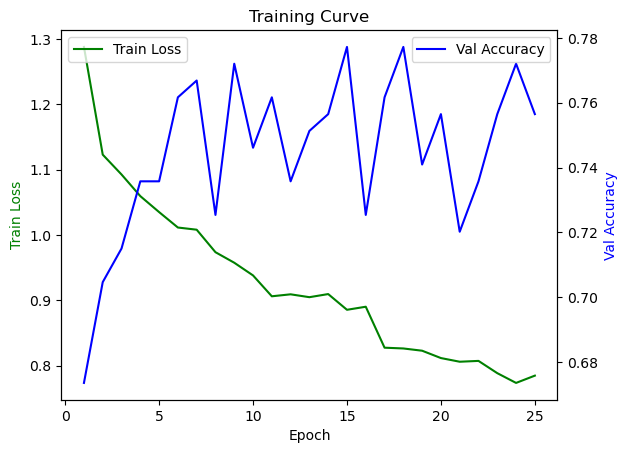

✅ Top-3 checkpoints: ['./checkpoints\\ep15_acc0.7772.pth', './checkpoints\\ep18_acc0.7772.pth', './checkpoints\\ep09_acc0.7720.pth']


In [34]:

import os
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score

# — Hyperparameters & paths —
epochs       = 30
ramp_epochs  = 10
ema_decay    = 0.999
mixup_alpha  = 0.4
enc_max_lr   = 1e-4
head_max_lr  = 1e-3
weight_decay = 1e-4
patience     = 7
CKPT_DIR     = "./checkpoints"
os.makedirs(CKPT_DIR, exist_ok=True)

# — Loss, optimizer, scheduler —
criterion = nn.CrossEntropyLoss(label_smoothing=0.1).to(device)
optimizer = AdamW([
    {'params': student.encoder.parameters(), 'lr': enc_max_lr},
    {'params': student.head.parameters(),    'lr': head_max_lr}
], weight_decay=weight_decay)

scheduler = OneCycleLR(
    optimizer,
    max_lr=[enc_max_lr, head_max_lr],
    steps_per_epoch=len(l_loader),
    epochs=epochs
)

# — MixUp helpers —
def mixup_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1.0
    B = x.size(0)
    idx = torch.randperm(B, device=x.device)
    x_mix = lam * x + (1 - lam) * x[idx]
    return x_mix, y, y[idx], lam

def mixup_loss(pred, y_a, y_b, lam):
    return lam * F.cross_entropy(pred, y_a, label_smoothing=0.1) \
         + (1-lam) * F.cross_entropy(pred, y_b, label_smoothing=0.1)

# — Track top-3 checkpoints —
best_ckpts = []
history = {'train_loss': [], 'val_acc': []}

for ep in range(1, epochs+1):
    student.train()
    total_sup, total_uns = 0.0, 0.0

    # ramp-up unsupervised weight
    λ_unsup = min(1.0, ep / ramp_epochs)
    thr     = 0.80 + 0.15 * (ep / epochs)

    unl_iter = iter(u_loader)
    pbar     = tqdm(l_loader, desc=f"Epoch {ep}/{epochs}", leave=False)

    for x_l, y_l, x_w, x_s in pbar:
        x_l, y_l = x_l.to(device), y_l.to(device)
        x_w, x_s = x_w.to(device), x_s.to(device)

        # — MixUp on labeled batch —
        x_mix, ya, yb, lam = mixup_data(x_l, y_l, alpha=mixup_alpha)
        out_mix = student(x_mix)
        loss_sup = mixup_loss(out_mix, ya, yb, lam)

        # — Pseudo-label & mask from weakly-aug unlabeled —
        with torch.no_grad():
            pt     = F.softmax(teacher(x_w), dim=1)
            maxp, pseudo = pt.max(1)
            mask   = maxp.ge(thr)

        # — MixUp on selected unlabeled —
        if mask.sum() > 0:
            xu = x_s[mask]; yu = pseudo[mask]
            # if only one sample, keep batch dim
            if xu.dim() == 3:
                xu = xu.unsqueeze(0)
                yu = yu.unsqueeze(0)
            xu_mix, ua, ub, lam_u = mixup_data(xu, yu, alpha=mixup_alpha)
            out_u    = student(xu_mix)
            loss_uns = mixup_loss(out_u, ua, ub, lam_u)
        else:
            loss_uns = torch.tensor(0.0, device=device)

        # — Total loss, backward, step —
        loss = loss_sup + λ_unsup * loss_uns
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()

        # — EMA teacher ← student —
        with torch.no_grad():
            for ps, pt in zip(student.parameters(), teacher.parameters()):
                pt.data.mul_(ema_decay).add_(ps.data, alpha=1-ema_decay)

        total_sup += loss_sup.item()
        total_uns += loss_uns.item()
        pbar.set_postfix({
            "sup": f"{total_sup/(pbar.n+1):.3f}",
            "uns": f"{total_uns/(pbar.n+1):.3f}"
        })

    history['train_loss'].append(total_sup / len(l_loader))

    # — Validation pass —
    student.eval()
    all_pred, all_gt = [], []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device)
            out = student(xb)
            all_pred += out.argmax(1).cpu().tolist()
            all_gt   += yb.tolist()
    val_acc = accuracy_score(all_gt, all_pred)
    history['val_acc'].append(val_acc)
    print(f"Epoch {ep:02d} → loss = {loss.item():.4f}, val_acc = {val_acc:.4f}")

    # — Save + keep top-3 ckpts —
    ckpt = os.path.join(CKPT_DIR, f"ep{ep:02d}_acc{val_acc:.4f}.pth")
    torch.save(student.state_dict(), ckpt)
    best_ckpts.append((val_acc, ckpt))
    best_ckpts = sorted(best_ckpts, key=lambda x: x[0], reverse=True)[:3]

    # — Early stopping on no new best top-1 —
    if val_acc >= best_ckpts[0][0]:
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f"→ Early stopping after {patience} epochs without new best")
            break
import matplotlib.pyplot as plt

# Plot training loss and validation accuracy
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(range(1, len(history['train_loss']) + 1), history['train_loss'], 'g-', label='Train Loss')
ax2.plot(range(1, len(history['val_acc']) + 1), history['val_acc'], 'b-', label='Val Accuracy')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Train Loss', color='g')
ax2.set_ylabel('Val Accuracy', color='b')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.title('Training Curve')
plt.show()

print("✅ Top-3 checkpoints:", [p for _, p in best_ckpts])



## CELL 6: ENSEMBLE + TTA (TEST-TIME AUGUMENTATION)

In [36]:

import torchvision.transforms as T

# 1) define TTA transforms
tta_tfs = [
    val_tf,
    T.Compose([T.RandomHorizontalFlip(1.0), val_tf]),
    T.Compose([T.RandomVerticalFlip(1.0),   val_tf]),
    T.Compose([T.RandomRotation(30),         val_tf])
]

# 2) load models
models_ens = []
for val_acc, ckpt_path in best_ckpts:  # Extract the path from the tuple
    m = copy.deepcopy(student)
    m.load_state_dict(torch.load(ckpt_path, map_location=device))  # Use the path directly
    m.eval()
    models_ens.append(m)

# 3) iterate test CSV directly
test_df = pd.read_csv(TEST_CSV)
all_pred, all_gt = [], []

for _, row in tqdm(test_df.iterrows(), total=len(test_df), desc="Ensemble TTA Test"):
    img_id = row['image']
    gt = int(row['label_idx'])
    pil = Image.open(os.path.join(TEST_DIR, f"{img_id}.jpg")).convert("RGB")

    # accumulate per‐model, per‐TTA probs
    agg = torch.zeros(len(label_cols), device=device)
    with torch.no_grad():
        for m in models_ens:
            for tfm in tta_tfs:
                x = tfm(pil).unsqueeze(0).to(device)
                agg += F.softmax(m(x), dim=1).squeeze(0)
    # average
    agg /= (len(models_ens) * len(tta_tfs))
    pred = int(agg.argmax().cpu())
    all_pred.append(pred)
    all_gt.append(gt)

# 4) report
test_acc = accuracy_score(all_gt, all_pred)
print(f"\n=== Ensemble TTA Test Accuracy: {test_acc*100:.2f}% ===\n")
print(classification_report(all_gt, all_pred, target_names=label_cols))


C:\Users\user\AppData\Local\Temp\ipykernel_13640\1548180956.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  m.load_state_dict(torch.load(ckpt_path, map_location=device)

Ensemble TTA Test:   0%|          | 0/1512 [00:00<?, ?it/s]


=== Ensemble TTA Test Accuracy: 70.30% ===

              precision    recall  f1-score   support

         MEL       0.54      0.35      0.42       171
          NV       0.80      0.92      0.85       909
         BCC       0.56      0.44      0.49        93
       AKIEC       0.32      0.30      0.31        43
         BKL       0.45      0.42      0.44       217
          DF       0.36      0.09      0.15        44
        VASC       0.71      0.49      0.58        35

    accuracy                           0.70      1512
   macro avg       0.53      0.43      0.46      1512
weighted avg       0.68      0.70      0.68      1512



## CELL 7: SHOW COFUSION MATRIX OF TEST

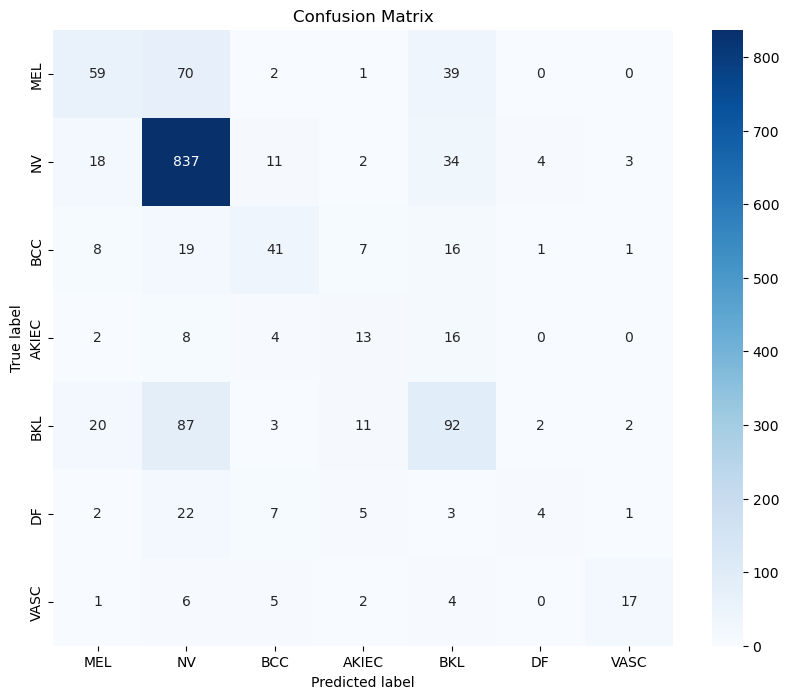

In [37]:
# Confusion matrix
cm = confusion_matrix(all_gt, all_pred)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_cols, yticklabels=label_cols)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()
